In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
import itertools
#from keras.preprocessing.image import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

np.random.seed(0)

<h1>Data Loading</h1>
<p>Setting up Image Data Generators<p>

In [2]:
#train_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/train",image_size=(256, 256))
#test_gen = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/valid",image_size=(256, 256))

train_gen = tf.keras.utils.image_dataset_from_directory(directory='F:/Dataset/train',
                                         image_size=(256, 256))
test_gen = tf.keras.utils.image_dataset_from_directory(directory="F:/Dataset/val",
                                        image_size=(256, 256))

rescale = Rescaling(scale=1.0/255)
train_gen = train_gen.map(lambda image,label:(rescale(image),label))
test_gen  = test_gen.map(lambda image,label:(rescale(image),label))

Found 43444 files belonging to 38 classes.
Found 10861 files belonging to 38 classes.


<h1>Data Engineering</h1>
<p>Since the data is already augmented, there is no requirement of data engineering. Feature scaling is automatically done by image generators</p>

<h1>Modelling</h1>

In [3]:
model = keras.Sequential()

model.add(keras.layers.Conv2D(64, (4, 4), activation="relu", padding="same", input_shape=(256, 256, 3)))
model.add(keras.layers.MaxPooling2D(3, 3))

model.add(keras.layers.Conv2D(128, (4, 4), activation="relu", padding="same"))
model.add(keras.layers.MaxPooling2D(3, 3))

model.add(keras.layers.Conv2D(256, (4, 4), activation="relu", padding="same"))
model.add(keras.layers.MaxPooling2D(3, 3))

model.add(keras.layers.Conv2D(512, (4, 4), activation="relu", padding="same", input_shape=(256, 256, 3)))
model.add(keras.layers.MaxPooling2D(3, 3))

model.add(keras.layers.Conv2D(1024, (4, 4), activation="relu", padding="same", input_shape=(256, 256, 3)))
model.add(keras.layers.MaxPooling2D(3, 3))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(512, activation="relu"))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(38, activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      3136      
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 128)       131200    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 28, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 256)       524544    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 256)         0

In [ ]:
ep = 3
history = model.fit_generator(train_gen,
          validation_data=test_gen,
          epochs = ep)

<h1>Metrics</h1>

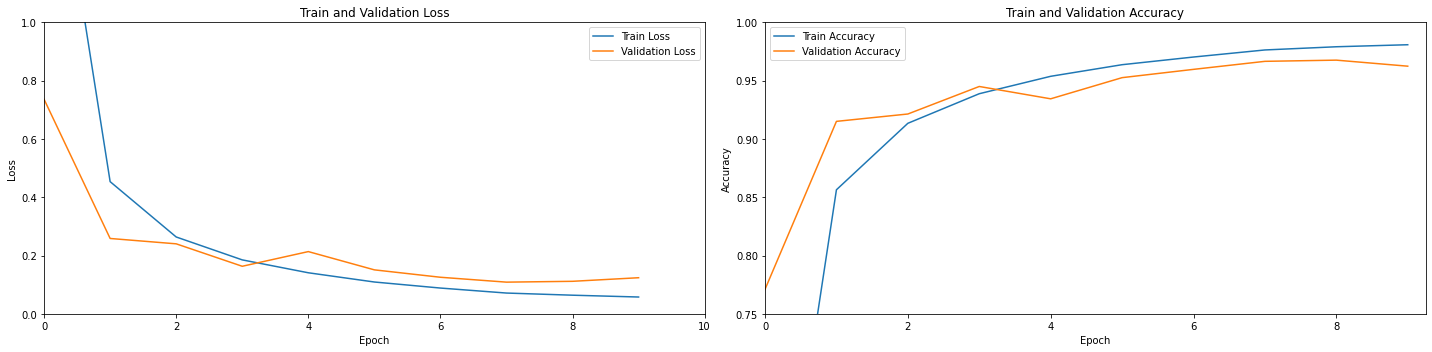

In [5]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(history.history['loss'],label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlim(0, 10)
plt.ylim(0.0,1.0)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0, 9.25)
plt.ylim(0.75,1.0)
plt.legend()
plt.tight_layout()

In [6]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())


In [7]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [8]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 98.08 %
Test Accuracy   : 96.24 %
Precision Score : 96.24 %
Recall Score    : 96.24 %


<h3>Confusion Matrix</h3>

<Figure size 1440x360 with 0 Axes>

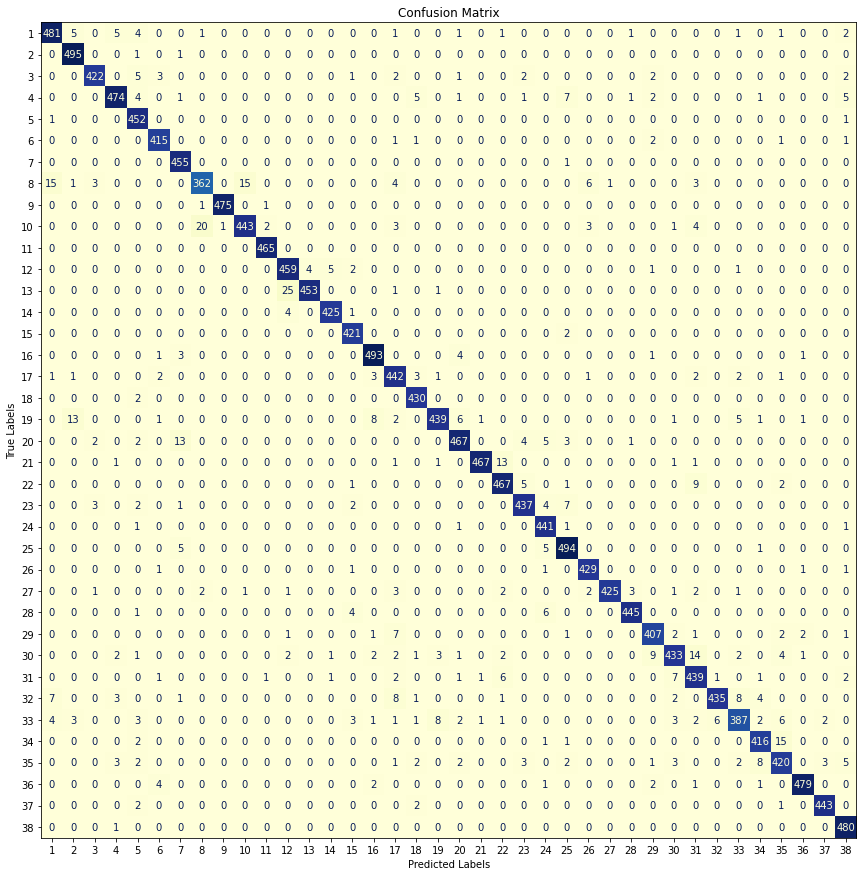

In [9]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()